## MERCI: Model Evaluation of Reliability for Classifier Inference - reliability analysis of classifiers

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import all the necessary packages
import merci
import sys
if ".." not in sys.path:
    sys.path.append("..")
import numpy as np
from  pipeline.datasets import load_german_credit

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Load example data (the breast cancer dataset) and create a classifier (logistic regression)

In [3]:
breast_cancer_data = load_breast_cancer(return_X_y=True)
X, y = breast_cancer_data

In [4]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# create model
model = LogisticRegression()

# train model
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9025341130604289


Add a random model to have a comparison between the metrics

In [5]:
class RandomModel:
    def __init__(self, seed: int = 1) -> None:
        np.random.seed(seed)
        self.num_classes = 0
        
    def fit(self, X, y):
        self.num_classes = len(np.unique(y))

    def predict_proba(self, X):
        result = np.random.uniform(0, 1, size=(X.shape[0], self.num_classes))
        return result / result.sum(axis=1).reshape(-1, 1)

    def predict(self, X):
        return np.random.randint(0, self.num_classes, X.shape[0])
 

### #1: TransductiveEvaluator

TransductiveEstimator evaluates a ML model's reliability through two steps:

1. Inductive step:

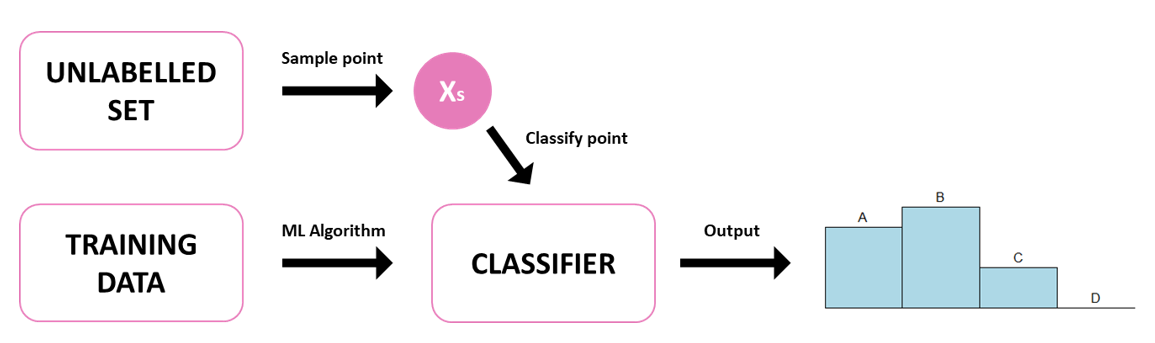
   
2. Trasductive step:

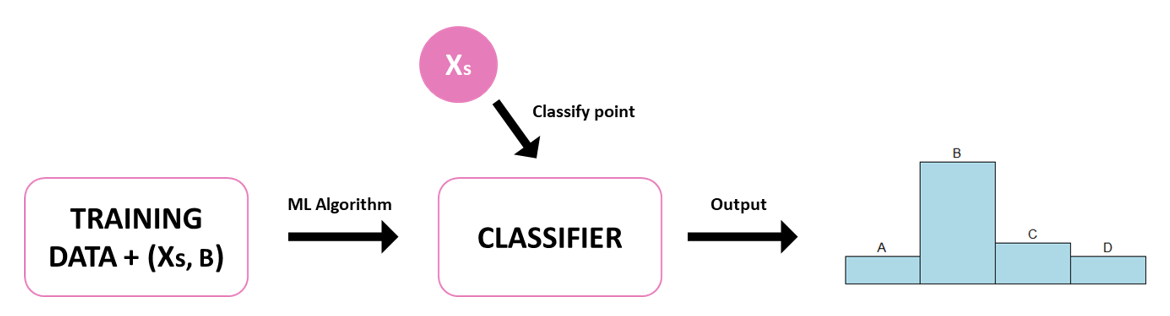

In [6]:
evaluator = merci.evaluate.TransductiveEvaluator(
    model, 
    (X_train, y_train), 
    (X_test, y_test),
)
evaluator.evaluate()

0.88651

In [7]:
random_model = RandomModel()
random_model.fit(X_train, y_train)

evaluator = merci.evaluate.TransductiveEvaluator(
    random_model, 
    (X_train, y_train), 
    (X_test, y_test),
)

evaluator.evaluate()

0.59674

### #2: DistributionShiftEvaluator

The idea is to evaluate the model performance on different conditions by varying the distribution of labels. For each class, and each threshold, a portion of the class data is randomly sampled according to the threshold. After training, the model is tested on the original test dataset and the F1 score is calculated (the resulting number is the average of F1 scores).

*Source:* [ A Fine-Grained Analysis on Distribution Shift (Wiles et al., 2022)](https://openreview.net/forum?id=Dl4LetuLdyK)

In [8]:
evaluator = merci.evaluate.DistributionShiftEvaluator(
    model, 
    (X_train, y_train), 
    (X_test, y_test),
)

evaluator.evaluate()

0.8556749134506583

In [9]:
evaluator = merci.evaluate.DistributionShiftEvaluator(
    random_model, 
    (X_train, y_train), 
    (X_test, y_test),
)

evaluator.evaluate()

0.5477467655693414

### #3: FairnessEvaluator

The FairnessEvaluator assesses the model's fairness using statistical measures based on predicted and actual outcomes. The class supports the following calculations:
- **predictive parity:** P(Y = 1|d = 1, G = m) = P(Y = 1|d = 1, G = f)
- **predictive equality:** P(d = 1|Y = 0, G = m) = P(d = 1|Y = 0, G = f)
- **equal opportunity:** P(d = 0|Y = 1, G = m) = P(d = 0|Y = 1, G = f)
- **equalized odds:** P(d = 1|Y = i, G = m) = P(d = 1|Y = i, G = f ), i ∈ 0, 1
- **conditional use accuracy:** (P(Y = 1|d = 1, G = m) = P(Y = 1|d = 1, G = f )) ∧ (P(Y = 0|d = 0, G = m) = P(Y = 0|d = 0, G = f))
- **overall accuracy equality:** P(d = Y , G = m) = P(d = Y , G = f )
- **treatment equality:** FN/FP (G = m) = FN/FP (G = f)

*Source:* [Fairness Definitions Explained](https://fairware.cs.umass.edu/papers/Verma.pdf)

Load the dataset with the sensitive attribute **gender (G)** and evaluate selected fairness measures:

In [10]:
gc_x, gc_y = load_german_credit()
X_gc_train, X_gc_test, y_gc_train, y_gc_test = train_test_split(gc_x, gc_y, test_size=0.1, random_state=42)

In [11]:
# select the fairness measure
meassure = "equal_opportunity"

In [12]:
model_gc = LogisticRegression()
model_gc.fit(X_gc_train, y_gc_train)

evaluator = merci.evaluate.FairnessEvaluator(
    model_gc, (X_gc_train, y_gc_train), (X_gc_test, y_gc_test)
)
print(evaluator.evaluate(measure=meassure))

0.21666666666666673


In [13]:
random_model = RandomModel()
random_model.fit(X_gc_train, y_gc_train)

evaluator = merci.evaluate.FairnessEvaluator(
    random_model, (X_gc_train, y_gc_train), (X_gc_test, y_gc_test)
)
print(evaluator.evaluate(measure=meassure))

0.15555555555555556


### #4: CalibrationEvaluator

Expected Calibration Error (ECE) is the metric used in this evaluator. It assesses how well a ML model's predicted probabilities align with the actual outcomes. It measures the difference between a model's confidence (predicted probabilities) and its accuracy across different bins of confidence levels. ECE calculates the weighted average of the absolute difference between accuracy and confidence within each bin. A lower ECE indicates better calibration, meaning the model's predicted probabilities closely match the true probabilities.

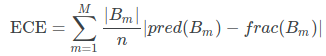

In [14]:
evaluator = merci.evaluate.CalibrationEvaluator(
    model, 
    (X_train, y_train), 
    (X_test, y_test),
)
evaluator.evaluate()

0.020643366388312667

In [15]:
random_model = RandomModel()
random_model.fit(X_gc_train, y_gc_train)

evaluator = merci.evaluate.CalibrationEvaluator(
    random_model, (X_gc_train, y_gc_train), (X_gc_test, y_gc_test)
)
print(evaluator.evaluate())

0.14841977452380772
